# Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm_notebook as tqdm

import os

In [2]:
from nets.simpleNet import simpleFCNet

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load Data

In [4]:
mode = 'minibatch'

if mode == 'batch':
    batch_size = 60000
elif mode == 'minibatch':
    batch_size = 64
elif mode == 'sgd':
    batch_size = 1
    
test_batch_size = 64

In [5]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, 
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))
                                                          ])),
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, download=True,
                                                         transform=transforms.Compose([
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.1307,), (0.3081,))
                                                         ])),
                                          batch_size=test_batch_size, shuffle=True)

## Show some sample images

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


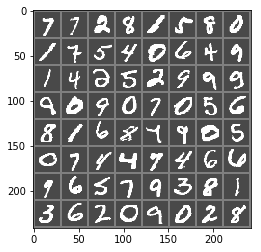

In [7]:
# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Experiments with growing networks

## 50 neurons

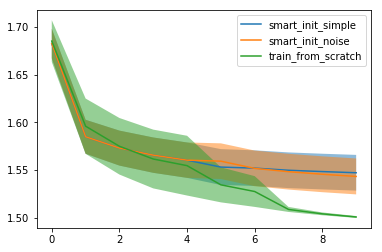

In [44]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/50 neurons/'

for method in os.listdir(parent_dir):
    method_dir = os.path.join(parent_dir, method)
    losses = []
    acc = []
    for f_name in os.listdir(method_dir):
        if f_name.startswith('loss'):
            losses.append(np.load(os.path.join(method_dir, f_name)))
        elif f_name.startswith('acc'):
            acc.append(np.load(os.path.join(method_dir, f_name)))
    losses = np.array(losses)
    plt.plot(np.arange(losses.shape[1]), np.mean(losses, 0), label=method)
    se = np.std(losses,0)/np.sqrt(losses.shape[0])
    plt.fill_between(np.arange(losses.shape[1]), np.mean(losses, 0)-se, np.mean(losses, 0)+se, alpha=0.5)
plt.legend()

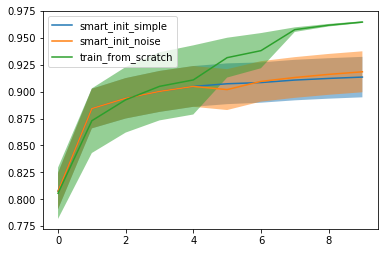

In [45]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/50 neurons/'

for method in os.listdir(parent_dir):
    method_dir = os.path.join(parent_dir, method)
    losses = []
    acc = []
    for f_name in os.listdir(method_dir):
        if f_name.startswith('acc'):
            acc.append(np.load(os.path.join(method_dir, f_name)))
    acc = np.array(acc)
    plt.plot(np.arange(acc.shape[1]), np.mean(acc, 0), label=method)
    se = np.std(acc,0)/np.sqrt(acc.shape[0])
    plt.fill_between(np.arange(acc.shape[1]), np.mean(acc, 0)-se, np.mean(acc, 0)+se, alpha=0.5)
plt.legend()

# 2 Hidden layers

## 50 neurons

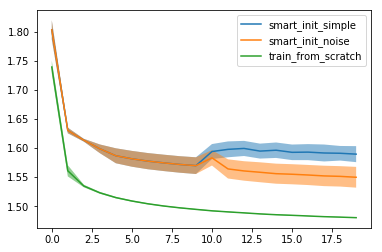

In [11]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/50 neurons/'

for method in os.listdir(parent_dir):
    method_dir = os.path.join(parent_dir, method)
    losses = []
    acc = []
    for f_name in os.listdir(method_dir):
        if f_name.startswith('loss'):
            losses.append(np.load(os.path.join(method_dir, f_name)))
        elif f_name.startswith('acc'):
            acc.append(np.load(os.path.join(method_dir, f_name)))
    losses = np.array(losses)
    plt.plot(np.arange(losses.shape[1]), np.mean(losses, 0), label=method)
    se = np.std(losses,0)/np.sqrt(losses.shape[0])
    plt.fill_between(np.arange(losses.shape[1]), np.mean(losses, 0)-se, np.mean(losses, 0)+se, alpha=0.5)
plt.legend()

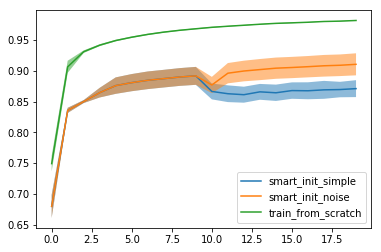

In [12]:
parent_dir = '/home/manu/Projects/dev/weightSymmetry/logs/50 neurons/'

for method in os.listdir(parent_dir):
    method_dir = os.path.join(parent_dir, method)
    losses = []
    acc = []
    for f_name in os.listdir(method_dir):
        if f_name.startswith('acc'):
            acc.append(np.load(os.path.join(method_dir, f_name)))
    acc = np.array(acc)
    plt.plot(np.arange(acc.shape[1]), np.mean(acc, 0), label=method)
    se = np.std(acc,0)/np.sqrt(acc.shape[0])
    plt.fill_between(np.arange(acc.shape[1]), np.mean(acc, 0)-se, np.mean(acc, 0)+se, alpha=0.5)
plt.legend()

1. Verify function-preservation
    - If it's correct, see why there's a jump in loss
2. Compare to teacher network
3. Double-check gradients go to zero after growing
4. More noise
5. Train for longer

Rethink small networks (8 neurons)